---
### model 3 : XGBoost
---

In [10]:
#앞서와 동일하게 데이터 전처리 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel", 
              rc={"font.size": 9, "axes.titlesize": 9, "axes.labelsize": 9,
              "xtick.labelsize": 9, "ytick.labelsize": 9})  

#data loading
data_path = 'kaggle/input/porto-seguro-safe-driver-prediction/'
train = pd.read_csv(data_path + 'train.csv', index_col = 'id')
test = pd.read_csv(data_path + 'test.csv', index_col = 'id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col = 'id')

#인코딩을 위한 데이터 합치기 
all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.drop('target', axis=1)
#전체 변수리스트  
all_features = all_data.columns 

#nominal features --> one-hot encoding 
from sklearn.preprocessing import OneHotEncoder
cat_features = [feature for feature in all_features if 'cat' in feature]

onehot_encoder = OneHotEncoder()
encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features])

#결측값 갯수를 파생변수로 
all_data['num_missing'] = (all_data == -1).sum(axis=1)

#remaining_features 정의 : nominal, calc이 아닌 변수
remaining_features = [feature for feature in all_features
                      if ('cat' not in feature and 'calc' not in feature) ]

#결측값 파생변수(num_minning) 추가
remaining_features.append('num_missing')

#모든 ind 변수들의 값을 _로 연결한 mix_ind 생성 
ind_features = [feature for feature in all_features
                if 'ind' in feature] 

is_first_feature = True 
for ind_feature in ind_features : 
    if is_first_feature : 
        all_data['mix_ind'] = all_data[ind_feature].astype(str) + '_'
        is_first_feature = False
    else : 
        all_data['mix_ind'] += all_data[ind_feature].astype(str) + '_'


#명목형 변수들(cat, mix_ind)의 고유값별 갯수를 파생변수로 만들기 
cat_count_features = []
for feature in cat_features+['mix_ind'] :
    val_counts_dict = all_data[feature].value_counts().to_dict()
    all_data[f'{feature}_count'] = all_data[feature].apply(lambda x : val_counts_dict[x])
    cat_count_features.append(f'{feature}_count')

## 생성된 변수들 
  #1) encoded_cat_matrix : 원핫 인코딩된 명목변수 
  #2) remaining_features : 명목형과 calc분류를 제외한 변수들 (num_missing 변수 추가)
  #3) cat_count_featues : max_ind를 포함한 명목평 변수들의 고유값별 갯수 

#불필요한 변수들 제거하고, 데이터 합치기 
from scipy import sparse 

drop_features = ['ps_ind_14', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_14']
all_data_remaining = all_data[remaining_features + cat_count_features].drop(drop_features, axis=1)

all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data_remaining), 
                               encoded_cat_matrix], format = 'csr')

#다시 train/test 데이터 분리 
num_train = len(train)

X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]
y = train['target'].values


- LightGBM과 XGBoost의 코드 차이 
  1) lgb.Dataset() --> xgb.DMatrix()
  2) gini() 함수 : lgb는 평가지표(gini)/평가점수(score)/점수가 높으면 좋은지 여부(True) 반환 --> xgb는 평가지표/평가점수 만 반환 
  3) eval_function() : 파라미터 문법 

In [11]:
#dataset 
import xgboost as xgb
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

#베이지안 최적화용 데이터셋
bayes_dtrain = xgb.DMatrix(X_train, y_train)
bayes_dvalid = xgb.DMatrix(X_valid, y_valid)

In [12]:
#파라미터 설정 
params_bounds = {'max_depth': (4,8),               ##트리의 최대깊이 
                 'subsample': (0.6, 0.9),          ##각 트리의 학습에 사용되는 데이터 샘플의 비율. 1보다 작으면 과적합을 줄이는 데 도움
                 'colsample_bytree': (0.7, 1.0),   ##각 트리의 학습에 사용되는 피처의 비율
                 'min_child_weight': (5, 7),       ##리프 노드가 되기 위해 필요한 최소한의 데이터 가중치 합. 값이 클수록 과적합이 감소
                 'gamma': (8, 11),                 ##트리의 리프 노드를 추가적으로 분할하기 위한 최소 손실 감소 값. 값이 클수록 모델의 복잡도가 낮아짐
                 'reg_alpha': (7, 9),              ##정규화 항의 가중치. 모델의 복잡도를 줄이기 위해 사용
                 'reg_lambda':(1.1, 1.5),          ##정규화 항의 가중치. 모델의 복잡도를 줄이기 위해 사용
                 'scale_pos_weight': (1.4, 1.6)}   ##불균형 데이터셋의 균형을 맞추기 위해 사용되는 양성 클래스의 가중치

fixed_params = {'objective': 'binary:logistic',    ##이진분류를 위해 로지스틱을 사용함 
                'learning_rate': 0.02, 
                'random_state': 1991 }

In [13]:
#XGBoost용 gini 함수 : 신백균 (https://www.kaggle.com/code/werooring/ch8-xgb-modeling)
def gini(preds, dtrain): 
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds)

def eval_gini(y_true, y_pred):
    # 실제값과 예측값의 크기가 같은지 확인 (값이 다르면 오류 발생)
    assert y_true.shape == y_pred.shape

    n_samples = y_true.shape[0]                      # 데이터 개수
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # 대각선 값

    # 1) 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()] # y_pred 크기순으로 y_true 값 정렬
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # 로렌츠 곡선
    G_pred = np.sum(L_mid - L_pred)       # 예측 값에 대한 지니계수

    # 2) 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()] # y_true 크기순으로 y_true 값 정렬
    L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
    G_true = np.sum(L_mid - L_true)       # 예측이 완벽할 때 지니계수

    # 정규화된 지니계수
    return G_pred / G_true

In [17]:
#베이지안 최적화를 위한 평가지표 계산 함수 
def eval_function(max_depth, subsample, colsample_bytree, min_child_weight,
                 reg_alpha, gamma, reg_lambda, scale_pos_weight):
    '''최적화하려는 평가지표(지니계수) 계산 함수'''
    # 베이지안 최적화를 수행할 하이퍼파라미터
    params = {'max_depth': int(round(max_depth)),      ##트리의 최대 깊이 
              'subsample': subsample,                  ##각 트리의 학습에 사용되는 데이터 샘플의 비율 설정. 1보다 작으면 과적합을 줄이는 데 도움
              'colsample_bytree': colsample_bytree,    ##각 트리의 학습에 사용되는 피처의 비율을 설정. 피처 샘플링을 통해 모델의 다변성을 높이고 과적합 감소
              'min_child_weight': min_child_weight,    ##리프 노드가 되기 위해 필요한 최소한의 데이터 가중치 합을 설정. 값이 클수록 모델이 더 보수적이게 되어 과적합 감소
              'gamma': gamma,                          ##트리의 리프 노드를 추가적으로 분할하기 위한 최소 손실 감소 값을 설정. 값이 클수록 모델의 복잡도가 낮아짐 
              'reg_alpha':reg_alpha,                   ##L1 정규화 항의 가중치를 설정
              'reg_lambda': reg_lambda,                ##L2 정규화 항의 가중치를 설정
              'scale_pos_weight': scale_pos_weight}    ##불균형 데이터셋의 균형을 맞추기 위해 사용되는 양성 클래스의 가중치를 설정. 클래스 불균형 문제를 해결하는 데 유용
    # 값이 고정된 하이퍼파라미터도 추가
    params.update(fixed_params)
    
    print('하이퍼파라미터 :', params)    
        
    # XGBoost 모델 훈련
    xgb_model = xgb.train(params=params, 
                          dtrain=bayes_dtrain,
                          num_boost_round=2000,
                          evals=[(bayes_dvalid, 'bayes_dvalid')],
                          maximize=True,
                          feval=gini,
                          early_stopping_rounds=200,
                          verbose_eval=False
                          )
                           
    best_iter = xgb_model.best_iteration # 최적 반복 횟수
    # 검증 데이터로 예측 수행
    preds = xgb_model.predict(bayes_dvalid, 
                              iteration_range=(0, best_iter))
    # 지니계수 계산
    gini_score = eval_gini(y_valid, preds)
    print(f'지니계수 : {gini_score}\n')
    
    return gini_score

In [18]:
#베이지안 최적화 수행 및 결과 확인 
from bayes_opt import BayesianOptimization
optimizer = BayesianOptimization(f = eval_function, 
                                 pbounds = params_bounds, 
                                 random_state = 0)

optimizer.maximize(init_points = 3, n_iter = 6)

#평가점수 최대일때의 파라미터값 출력 
max_params = optimizer.max['params']
print(max_params)

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
하이퍼파라미터 : {'max_depth': 6, 'subsample': 0.867531900234624, 'colsample_bytree': 0.8646440511781974, 'min_child_weight': 6.0897663659937935, 'gamma': 10.14556809911726, 'reg_alpha': 7.84730959867781, 'reg_lambda': 1.3583576452266626, 'scale_pos_weight': 1.4875174422525386, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}


c:\Users\Seoyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


지니계수 : 0.2770918995329271

| 1         | 0.2771    | 0.8646    | 10.15     | 6.411     | 6.09      | 7.847     | 1.358     | 1.488     | 0.8675    |
하이퍼파라미터 : {'max_depth': 7, 'subsample': 0.6261387899104622, 'colsample_bytree': 0.9890988281503088, 'min_child_weight': 6.0577898395058085, 'gamma': 9.150324556477333, 'reg_alpha': 8.136089122187865, 'reg_lambda': 1.4702386553170643, 'scale_pos_weight': 1.4142072116395774, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}
지니계수 : 0.2785348596472599

| 2         | 0.2785    | 0.9891    | 9.15      | 7.167     | 6.058     | 8.136     | 1.47      | 1.414     | 0.6261    |
하이퍼파라미터 : {'max_depth': 7, 'subsample': 0.8341587528859367, 'colsample_bytree': 0.7060655192320977, 'min_child_weight': 6.7400242964936385, 'gamma': 10.497859536643814, 'reg_alpha': 8.957236684465528, 'reg_lambda': 1.4196634256866894, 'scale_pos_weight': 1.4922958724505864, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}

c:\Users\Seoyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


지니계수 : 0.27763413318913566

| 4         | 0.2776    | 0.8843    | 10.45     | 6.838     | 6.494     | 8.552     | 1.381     | 1.423     | 0.7002    |
하이퍼파라미터 : {'max_depth': 7, 'subsample': 0.8535233675350644, 'colsample_bytree': 0.92975858050776, 'min_child_weight': 6.249564429359247, 'gamma': 9.95563546750357, 'reg_alpha': 8.411512219837842, 'reg_lambda': 1.424460008293778, 'scale_pos_weight': 1.5416807226581535, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}


c:\Users\Seoyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


지니계수 : 0.27812576532574423

| 5         | 0.2781    | 0.9298    | 9.956     | 6.809     | 6.25      | 8.412     | 1.424     | 1.542     | 0.8535    |
하이퍼파라미터 : {'max_depth': 7, 'subsample': 0.6462619019069298, 'colsample_bytree': 0.80929192865947, 'min_child_weight': 6.079999276892042, 'gamma': 9.553916776586505, 'reg_alpha': 8.860396362258099, 'reg_lambda': 1.4050740023119348, 'scale_pos_weight': 1.4668544695338273, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}


c:\Users\Seoyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


지니계수 : 0.27915174611271043

| 6         | 0.2792    | 0.8093    | 9.554     | 6.532     | 6.08      | 8.86      | 1.405     | 1.467     | 0.6463    |
하이퍼파라미터 : {'max_depth': 7, 'subsample': 0.6931141936797243, 'colsample_bytree': 0.8817801730078565, 'min_child_weight': 6.992334203641873, 'gamma': 9.013424730095146, 'reg_alpha': 7.640858389939128, 'reg_lambda': 1.3562805915715632, 'scale_pos_weight': 1.449446257931491, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}


c:\Users\Seoyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


지니계수 : 0.2810739973185967

| 7         | 0.2811    | 0.8818    | 9.013     | 6.927     | 6.992     | 7.641     | 1.356     | 1.449     | 0.6931    |
하이퍼파라미터 : {'max_depth': 7, 'subsample': 0.6189980960881654, 'colsample_bytree': 0.7878446238314734, 'min_child_weight': 7.0, 'gamma': 8.48342121044768, 'reg_alpha': 7.6248397474491245, 'reg_lambda': 1.271681379512945, 'scale_pos_weight': 1.4627902889435795, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}


c:\Users\Seoyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


지니계수 : 0.2805923447688805

| 8         | 0.2806    | 0.7878    | 8.483     | 6.742     | 7.0       | 7.625     | 1.272     | 1.463     | 0.619     |
하이퍼파라미터 : {'max_depth': 7, 'subsample': 0.722424393855613, 'colsample_bytree': 1.0, 'min_child_weight': 7.0, 'gamma': 8.764657618443177, 'reg_alpha': 7.0, 'reg_lambda': 1.322083071699482, 'scale_pos_weight': 1.4331835191119615, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}


c:\Users\Seoyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


지니계수 : 0.28019787207872776

| 9         | 0.2802    | 1.0       | 8.765     | 7.361     | 7.0       | 7.0       | 1.322     | 1.433     | 0.7224    |
{'colsample_bytree': 0.8817801730078565, 'gamma': 9.013424730095146, 'max_depth': 6.927417000715145, 'min_child_weight': 6.992334203641873, 'reg_alpha': 7.640858389939128, 'reg_lambda': 1.3562805915715632, 'scale_pos_weight': 1.449446257931491, 'subsample': 0.6931141936797243}


In [20]:
#max_depth를 정수로 변환 & fixed_params 추가 
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params.update(fixed_params)
max_params


{'colsample_bytree': 0.8817801730078565,
 'gamma': 9.013424730095146,
 'max_depth': 7,
 'min_child_weight': 6.992334203641873,
 'reg_alpha': 7.640858389939128,
 'reg_lambda': 1.3562805915715632,
 'scale_pos_weight': 1.449446257931491,
 'subsample': 0.6931141936797243,
 'objective': 'binary:logistic',
 'learning_rate': 0.02,
 'random_state': 1991}

In [24]:
#model training and validation 
from sklearn.model_selection import StratifiedKFold


#k-fold = 5로 설정하고, 예측값을 담을 배열 생성  
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991)
oof_val_preds = np.zeros(X.shape[0])
oof_test_preds = np.zeros(X_test.shape[0])

#model train, predict, validation 
for idx, (train_idx, valid_idx) in enumerate(folds.split(X,y)): 
    print("#"*50, f'fold {idx+1} / fold {folds.n_splits}', "#"*50)

    X_train, y_train = X[train_idx], y[train_idx]    ##train data
    X_valid, y_valid = X[valid_idx], y[valid_idx]    ##valid data

    dtrain = xgb.DMatrix(X_train, y_train)           ##XGBoost용 train data
    dvalid = xgb.DMatrix(X_valid, y_valid)           ##XGBoost용 valid data
    dtest  = xgb.DMatrix(X_test)                     ##XGBoost용 test data

    #XGB model training 
    xgb_model = xgb.train(params = max_params, 
                          dtrain = dtrain, 
                          num_boost_round = 2000, 
                          evals = [(dvalid, 'valid')], 
                          maximize = True, 
                          feval = gini, 
                          early_stopping_rounds=200,
                          verbose_eval = 100)
    
    #best model의 boosting 반복횟수 저장 
    best_iter = xgb_model.best_iteration
    
    #모델의 예측값 
    oof_test_preds += xgb_model.predict(dtest, iteration_range = (0, best_iter)) / folds.n_splits
    oof_val_preds[valid_idx] += xgb_model.predict(dvalid, iteration_range = (0, best_iter))

    #정규화 gini score 
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    print(f'fold {idx+1} gini_score: {gini_score} \n')

################################################## fold 1 / fold 5 ##################################################


c:\Users\Seoyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	valid-logloss:0.21782	valid-gini:0.20558
[100]	valid-logloss:0.16039	valid-gini:0.27314
[200]	valid-logloss:0.15515	valid-gini:0.28562
[300]	valid-logloss:0.15442	valid-gini:0.29090
[400]	valid-logloss:0.15431	valid-gini:0.29224
[500]	valid-logloss:0.15427	valid-gini:0.29258
[600]	valid-logloss:0.15425	valid-gini:0.29267
[700]	valid-logloss:0.15424	valid-gini:0.29316
[800]	valid-logloss:0.15423	valid-gini:0.29351
[900]	valid-logloss:0.15425	valid-gini:0.29358
[1000]	valid-logloss:0.15421	valid-gini:0.29381
[1100]	valid-logloss:0.15421	valid-gini:0.29386
[1200]	valid-logloss:0.15421	valid-gini:0.29392
[1300]	valid-logloss:0.15421	valid-gini:0.29396
[1400]	valid-logloss:0.15420	valid-gini:0.29403
[1500]	valid-logloss:0.15420	valid-gini:0.29406
[1600]	valid-logloss:0.15419	valid-gini:0.29413
[1700]	valid-logloss:0.15420	valid-gini:0.29414
[1800]	valid-logloss:0.15419	valid-gini:0.29432
[1900]	valid-logloss:0.15418	valid-gini:0.29431
[1999]	valid-logloss:0.15420	valid-gini:0.29435
fold

In [25]:
#결과 제출 
print('gini_score_valid = ', eval_gini(y, oof_val_preds))
print('gini_score_test = ', oof_test_preds)

submission['target'] = oof_test_preds
submission.to_csv('submission.csv')

gini_score_valid =  0.284420290669874
gini_score_test =  [0.03784185 0.03710503 0.03765548 ... 0.05027968 0.03310417 0.04339978]


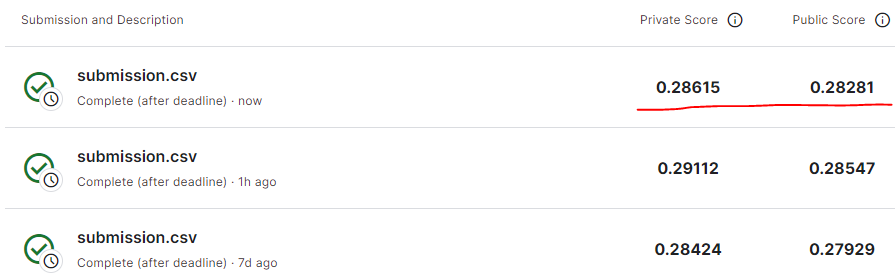

In [26]:
from IPython.display import Image
Image("images/gini_3.PNG")